# Model hyper-parameter tuning & evaluation

## Abstract

This notebook runs the hyperparameter tuning of the production model.

The production model is an XGBoost regressor.
<br>The following features are used:

The hyperparameters to tune are:
- `max_depth` of the trees along the integer interval: `[3, 10]`
- `learning_rate` of the optimisation method across the log scale from `0.01` to `1`
- `n_estimators` or number of trees along the integer interval: `[50, 1000]`

We set a maximum of 20 trials.

_NB: for all trials, `gamma` is set to `0` while `subsample` to `1`._

__RMSE__ is used as the metric to evaluate for the hypertuning.

<br>During this stage, the process is the following:
- the _original training_ data is split into train/test sets in a 70% / 30% fashion;
- for each combination of hyperparameters values, a 5-fold cross validation happens on the train set;
- the average of the 5 RMSEs reported during cross-validation is used to quantify the performance of the hyperparameters values;
- with the same hyperparameters values, the model is trained on the entire train set then validated on the test set;
- the full picture of metrics during the test is serialized on Cloud Storage in the __modelling_serializations__ folder;
- with the hyperparameters values frozen, the model is fully trained on the _original training_ data (100% of data available) and saved in Cloud Storage in the __modelling_serializations__ folder.

## Hyperparameter tuning using Vertex AI

In [1]:
%%bash

sh hyperopt.sh

jobId: blackfriday_ml_hypertune_model_20200216_193814
state: QUEUED


Job [blackfriday_ml_hypertune_model_20200216_193814] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe blackfriday_ml_hypertune_model_20200216_193814

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs blackfriday_ml_hypertune_model_20200216_193814


From the [AI Platform job details](https://console.cloud.google.com/ai-platform/jobs/blackfriday_ml_hypertune_model_20200216_193814/charts/cpu?project=szilard-kalosi-sandbox),

the best model trained has the following hyperparameter values:
- `max_depth` = 9
- `learning_rate` = 0.31619
- `n_estimators` = 767
- `subsample` = 1
- `gamma` = 0

Let's freeze those hyperparameter values and make some additional experiments to have a more detailed picture.
<br>For instance, we will plot the distributions of predictions.

### Optimised XGBoost

Splitting data into 70% / 30% train vs. test sets
Training...
[10:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
   Training time: 214.12 s
Evaluating training performance...


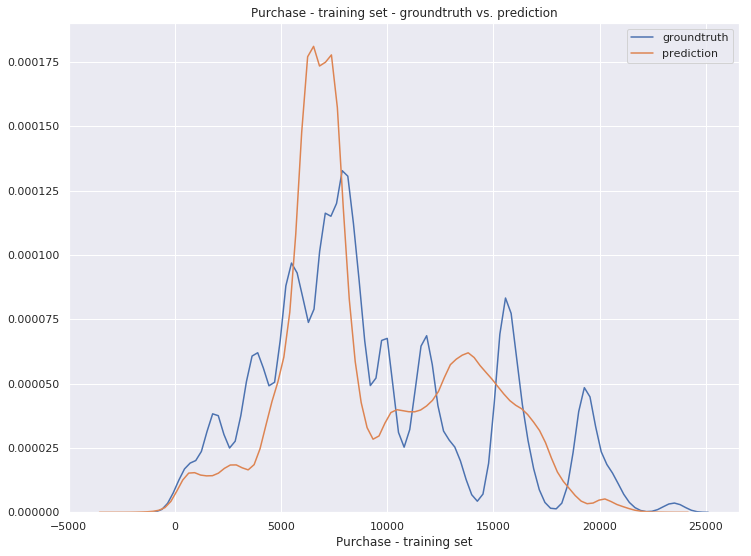

   Evaluation time: 93.70 s
Evaluating test performance...


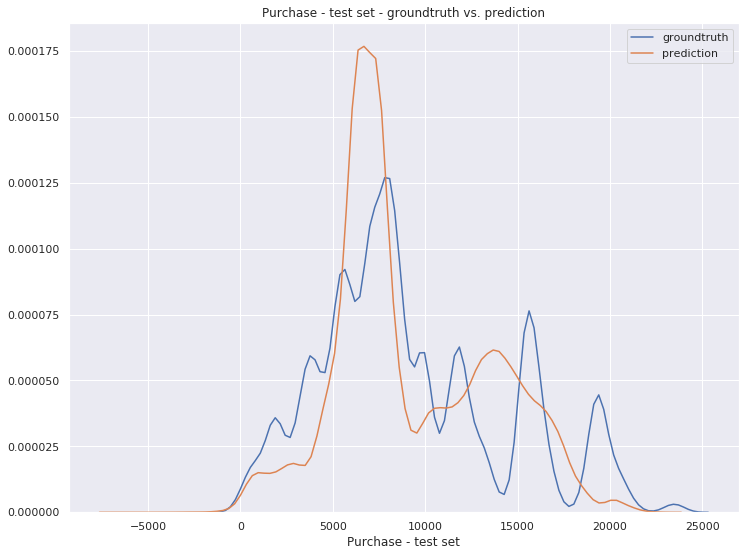

   Evaluation time: 40.32 s


In [1]:
from trainer_experiments.model_2 import train_eval
from xgboost import XGBRegressor

params = {
    'n_estimators': 767, 'learning_rate': 0.31619, 'max_depth': 9, 'subsample': 1.0, 'gamma': 0,
    'random_state': 18, 'n_jobs': -1
}

XGB_model, XGB_training_perf, XGB_test_perf = train_eval([('regressor', XGBRegressor(**params))])

In [2]:
XGB_training_perf

,metric value
max_error,12770.875000
r2,0.807636
R2,0.805511
MedAE,1316.541992
MAE,1677.799332
RMSE,2215.746479
explained_variance,0.805511


In [3]:
XGB_test_perf

,metric value
max_error,15491.662109
r2,0.746775
R2,0.746620
MedAE,1432.526367
MAE,1876.697044
RMSE,2527.036146
explained_variance,0.746620


Compared to the baseline showed in [Training experiments](https://6fbe85b20ee1f013-dot-datalab-vm-us-west1.googleusercontent.com/lab/tree/Demo%20#2/4.%20Training%20experiments.ipynb), we can highlight the following remarks:
- the XGBoost better learns on the training set (XGBoost RMSE = 2215 vs. baseline RMSE = 2451)
- however the XGBoost performs a little worse than the baseline on the test set (XGBoost RMSE = __2527__ vs. baseline RMSE = __2502__) - which is due to the more sophisticated nature of the ensemble of decision trees compared to a linear regression
- in terms of plots, the XGBoost really tries to fit to the groundtruth distribution while the baseline has a lazier & smoother behavior

At that stage, we can guess that the XGBoost could be better optimised with a longer hypertuning phase.
_Keep in mind that for the sake of a simple demonstration, we set the hypertuning phase to a maximum of 20 trials only, which is quite mean compared to the hyperparameter space to explore._
<br>Another consideration would be to even broaden the hyperparameter space to other hyperparameters like `gamma` or `subsample`.
<br>A last consideration would be to integrate some dimensionality reduction as a preprocessing step, like we did during the [Training experiments](https://6fbe85b20ee1f013-dot-datalab-vm-us-west1.googleusercontent.com/lab/tree/Demo%20#2/4.%20Training%20experiments.ipynb).

Let's make a last experiment by adding an SVD decomposition in prior of the XGBoost model.
<br>We will take an arbitrary number of `n_components` of `100` to embed our initial very high dimensionality feature space - like we did in prior.

## Hyperparameter tuning using Optuna

Models with short teaching times should be optimized locally for hyperparameters. Although the Vertex AI offers a good option, it is especially worth using for high-computational models, as jobs start up in a relatively long time.

Optuna is a hyperparameter optimization framework. It offers a good local alternative to Vertex AI. Other similar frameworks such as Hyperopt can also be used as well.

In [ ]:
import optuna
from hyperparameter_optimization.hyperopt_w_optuna import objective


study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=3,
    n_jobs=4,
    show_progress_bar=True
)
print(study.best_trial)